In [41]:
import librosa
import numpy as np
import time
import os
from sporco.admm import cbpdn
import sporco.metric as sm
import pickle 
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema
import scipy.io.wavfile
import math
from copy import deepcopy
from midiutil import MIDIFile
%matplotlib inline


In [ ]:
# sample rate (reduced for faster algorithm runtime)
sr = 11025
window_size = 0.050

# path of signal to approximate
songname = "MAPS_MUS-alb_esp2_SptkBGCl.wav"

# path of ground-truth file used to calculate f-measure
gt_name = 'MAPS_MUS-alb_esp2_SptkBGCl.txt'

# length of signal to approximate in seconds. Recommended to keep under 30s
duration = 30.0

# filename abbreviation for caching output of CBPDN algorithm
abbrev = 'esp2'

In [18]:
# load the dictionary for the individual notes. This section will need to be modified depending
# on the structure of your directory and where your training set is placed.

D = []
directory = './maps/notes/'
dictname = 'mapsdict'
for i in range(21,109):
    fname1 = 'MAPS_ISOL_NO_F_S0_M' + str(i) + '_SptkBGCl.wav'
    fname2 = 'MAPS_ISOL_NO_F_S1_M' + str(i) + '_SptkBGCl.wav'
    
    try:
        s = librosa.load(directory + fname1, sr=11025,offset=0.7,duration=1.0)[0]
    except:
        s = librosa.load(directory + fname2, sr=11025,offset=0.7,duration=1.0)[0]
    # normalize dictionary elements
    D.append(s/np.amax(s))
    
# cast to np array
D = np.asarray(D)

# transpose to fit the dimension requirements of the optimization algorithm
D = D.T

# use pickle to save the dictionary
with open(dictname + '.pkl','wb') as fid:
     pickle.dump(D,fid)

In [72]:
# load the dictionary from disk

with open(dictname + '.pkl','rb') as fid:
    D = pickle.load(fid)
    
# should be 11025 x 88
print(D.shape)

(11025, 88)


In [42]:
# initalize parameters for solving algorithm
lmbda = 0.005

# 1 temporal dimension
dimN = 1

# configure options. HighMemSolve is set to false due to intensive memory requirements. RelStopTol
# and MaxMainIter can be changed to yield better results at the cost of runtime
opt = cbpdn.ConvBPDN.Options({'Verbose' : True, 'MaxMainIter' : 500,
                    'HighMemSolve' : False, 'LinSolveCheck' : False,
                    'RelStopTol' : 1e-3, 'AuxVarObj' : False})


# load the full polyphonic song we are trying to approximate
# change depending on path of song
songdir = "./maps/songs/"
song, sr = librosa.load(songdir+songname,sr=sr, duration = duration)

# should be of length sr * duration
print(song.shape)

(661500,)


In [76]:
# begin CBPDN algorithm
b = cbpdn.ConvBPDN(D, song, lmbda, opt,dimN=dimN)

# time the solve() method
starttime = time.time()
X = b.solve()
endtime = time.time()
print("solving took: ", endtime-starttime, " seconds")

# flatten extra dimensions of array for easier peak-picking
X = X[:,0,0,:]

# save the result of the algorithm so we don't have to run it multiple times
# label appropriately
results_name = 'maps_results_' + 'esp6' + '.pkl'
with open(results_name, 'wb') as fid:
    pickle.dump(X, fid)

Itn   Fnc       DFid      Regℓ1     r         s         ρ         
----------------------------------------------------------------
   0  4.28e+00  3.78e+00  9.98e+01  1.00e+00  0.00e+00  1.25e+00
   1  4.22e+00  3.72e+00  9.97e+01  1.00e+00  0.00e+00  1.25e+00
   2  4.89e-01  4.34e-02  8.91e+01  3.82e-01  2.47e+00  1.25e+03
   3  6.99e-01  1.13e-02  1.37e+02  4.78e-01  6.69e-01  4.86e+02
   4  5.90e-01  7.31e-03  1.17e+02  4.31e-01  4.34e-01  4.06e+02
   5  4.95e-01  8.07e-03  9.74e+01  3.33e-01  2.85e-01  4.06e+02
   6  4.39e-01  7.71e-03  8.62e+01  2.44e-01  2.37e-01  4.06e+02
   7  3.94e-01  6.94e-03  7.75e+01  1.92e-01  2.04e-01  4.06e+02
   8  3.46e-01  6.62e-03  6.79e+01  1.53e-01  1.79e-01  4.06e+02
   9  3.11e-01  6.64e-03  6.09e+01  1.21e-01  1.57e-01  4.06e+02
  10  3.01e-01  6.62e-03  5.89e+01  1.09e-01  1.40e-01  3.53e+02
  11  2.93e-01  6.46e-03  5.73e+01  9.84e-02  1.26e-01  3.08e+02
  12  2.82e-01  6.28e-03  5.52e+01  8.96e-02  1.12e-01  2.69e+02
  13  2.72e-01  6.13e-0

In [43]:
# load the ground-truth file for the song
f = open(songdir + gt_name, 'rb')
lines = f.readlines()[1:]
GT = {}
num_timesets = 0

# parse ground-truth text file into dictionary GT
# for a note number n that occurs in the song, GT[n] gives an array of onsets and offsets for that note
for row in lines:
    row = row.decode().strip('\r\n')
    row = row.split('\t')
    note = row[2]
    start = row[0]
    end = row[1]
    if float(start) > duration:
        break
    else:        
        if note in GT:
            GT[note].append([start, end])
        else:
            GT[note] = [[start, end]]
    num_timesets += 1
    
print (num_timesets)

170


In [44]:
# load activation vectors from disk
with open(results_name,'rb') as Y:
    Y1 = pickle.load(Y)


In [51]:
# not necessary, but useful in the case where you want to modify Y multiple times
Y = deepcopy(Y1)

# take the first 30 seconds (if original signal was longer)
Y = Y[0:330750,:]

# should be 330750 x 88
print(Y.shape)
lmaxes = np.asarray([])

# find the local maxima at each timestep, ignoring negative peaks
for row in Y:
    relex = argrelextrema(row,np.greater)[0]
    lmaxes = np.concatenate((lmaxes,row[relex]))

(330750, 88)


In [52]:
# calculate q3 and q1
p75,p25 = np.percentile(lmaxes, [75,25])

# pick the binarization threshold based on the inter-quartile range
threshold = p75 + 8*(p75-p25)

# binarize
lowvals = Y < threshold
Y[lowvals] = 0
print(threshold)

0.00129215355264


In [53]:
# vars intialization for parsing the 50ms windows
window_size = 0.05
start = 0
l = int(sr*window_size)
end = l
window = 0

# 2D array that represents onsets
onsets = np.zeros((88,int(duration/0.05)))
# highest and lowest note (for plotting purposes)
highnote = 0
lownote = 100
total = 0
correct = 0
poped = 0
GT_cpy = deepcopy(GT)

for i in range(int(duration/window_size)):
    row = Y[start:end,:]
    #print(row.shape)
    sumrow = np.sum(row,axis=0)
    relex = argrelextrema(sumrow,np.greater)[0]
    if(len(relex) != 0):
        # time index that the note occurs
        high = np.amax(relex)
        low = np.amin(relex)
        if high > highnote:
            highnote = high
        if low < lownote:
            lownote = low
        tindex = window
        onsets[relex,tindex] = 1
        t = window_size * window
        
        for note in relex:
            note += 21
            total += 1
            if str(note) in GT:
                time_ranges = GT[str(note)]
                for time_range in time_ranges:
                    s = float(time_range[0])
                    e = float(time_range[1])
                    if t < s - window_size:
                        break
                    elif t >= s - window_size and t <= e + window_size:
                        correct += 1
                        break

            if str(note) in GT_cpy:
                time_ranges = deepcopy(GT_cpy[str(note)]) 
                for i in range(len(time_ranges)):
                    s = float(time_ranges[i][0])                   
                    e = float(time_ranges[i][1])
                    if t < s - window_size:
                        break
                    elif t >= s - window_size and t <= e + window_size:
                        time_ranges.pop(i)
                        GT_cpy[str(note)] = time_ranges
                        poped += 1
                        break
    start = end
    end += l
    window+=1


precision = float(correct) / total
print ("Correct percentage is: " + str(precision))

recall = float(poped) / num_timesets
print ("Detected percentage is: " + str(recall))

f1 = 2 * ((precision * recall) / (precision + recall))
print ("f1 is: " + str(f1))

Correct percentage is: 0.7138461538461538
Detected percentage is: 0.9764705882352941
f1 is: 0.8247563979012741


In [54]:
# plot ground truth
# print(GT)
# get the ground truth for the same duration as onsets
lasttime = onsets.shape[-1] * window_size
gt_plot = np.zeros(onsets.shape)
for key in GT:
    # MIDI notes are offset by 21
    note = int(key) - 21
    # val is array of arrays, where val[i] denotes the ith [onset,offset]
    val = GT[key]
    # for each onset/offset pair
    for oopair in val:
        start = float(oopair[0])
        if start < lasttime:
            # round nearest 50ms interval
            #print(note)
            t_index = math.floor(start/window_size)
            gt_plot[note,t_index] = 1

In [55]:
# remove temporal information
for i in range(onsets.shape[1]-1):
    curr = onsets[:,i]
    nxt = onsets[:,i+1]
    # take differnce of two frames
    chnge = nxt - curr
    # where change = 0, we want to set next to 0
    indices = chnge < 1
    onsets[indices,i+1] = 0
    

# transform data so we can do a scatterplot
x1 = []
y1 = []
x2 = []
y2 = []
for i in range(onsets.shape[1]):
        col1 = onsets[:,i]
        col2 = gt_plot[:,i]
        # get indices where note is playing
        counter = 0
        for c1 in col1:
            if c1:
                x1.append(i)
                y1.append(counter)
            counter +=1
        counter = 0
        for c2 in col2:
            if c2:
                x2.append(i)
                y2.append(counter)
            counter+=1
print(len(x1),len(x2))

259 170


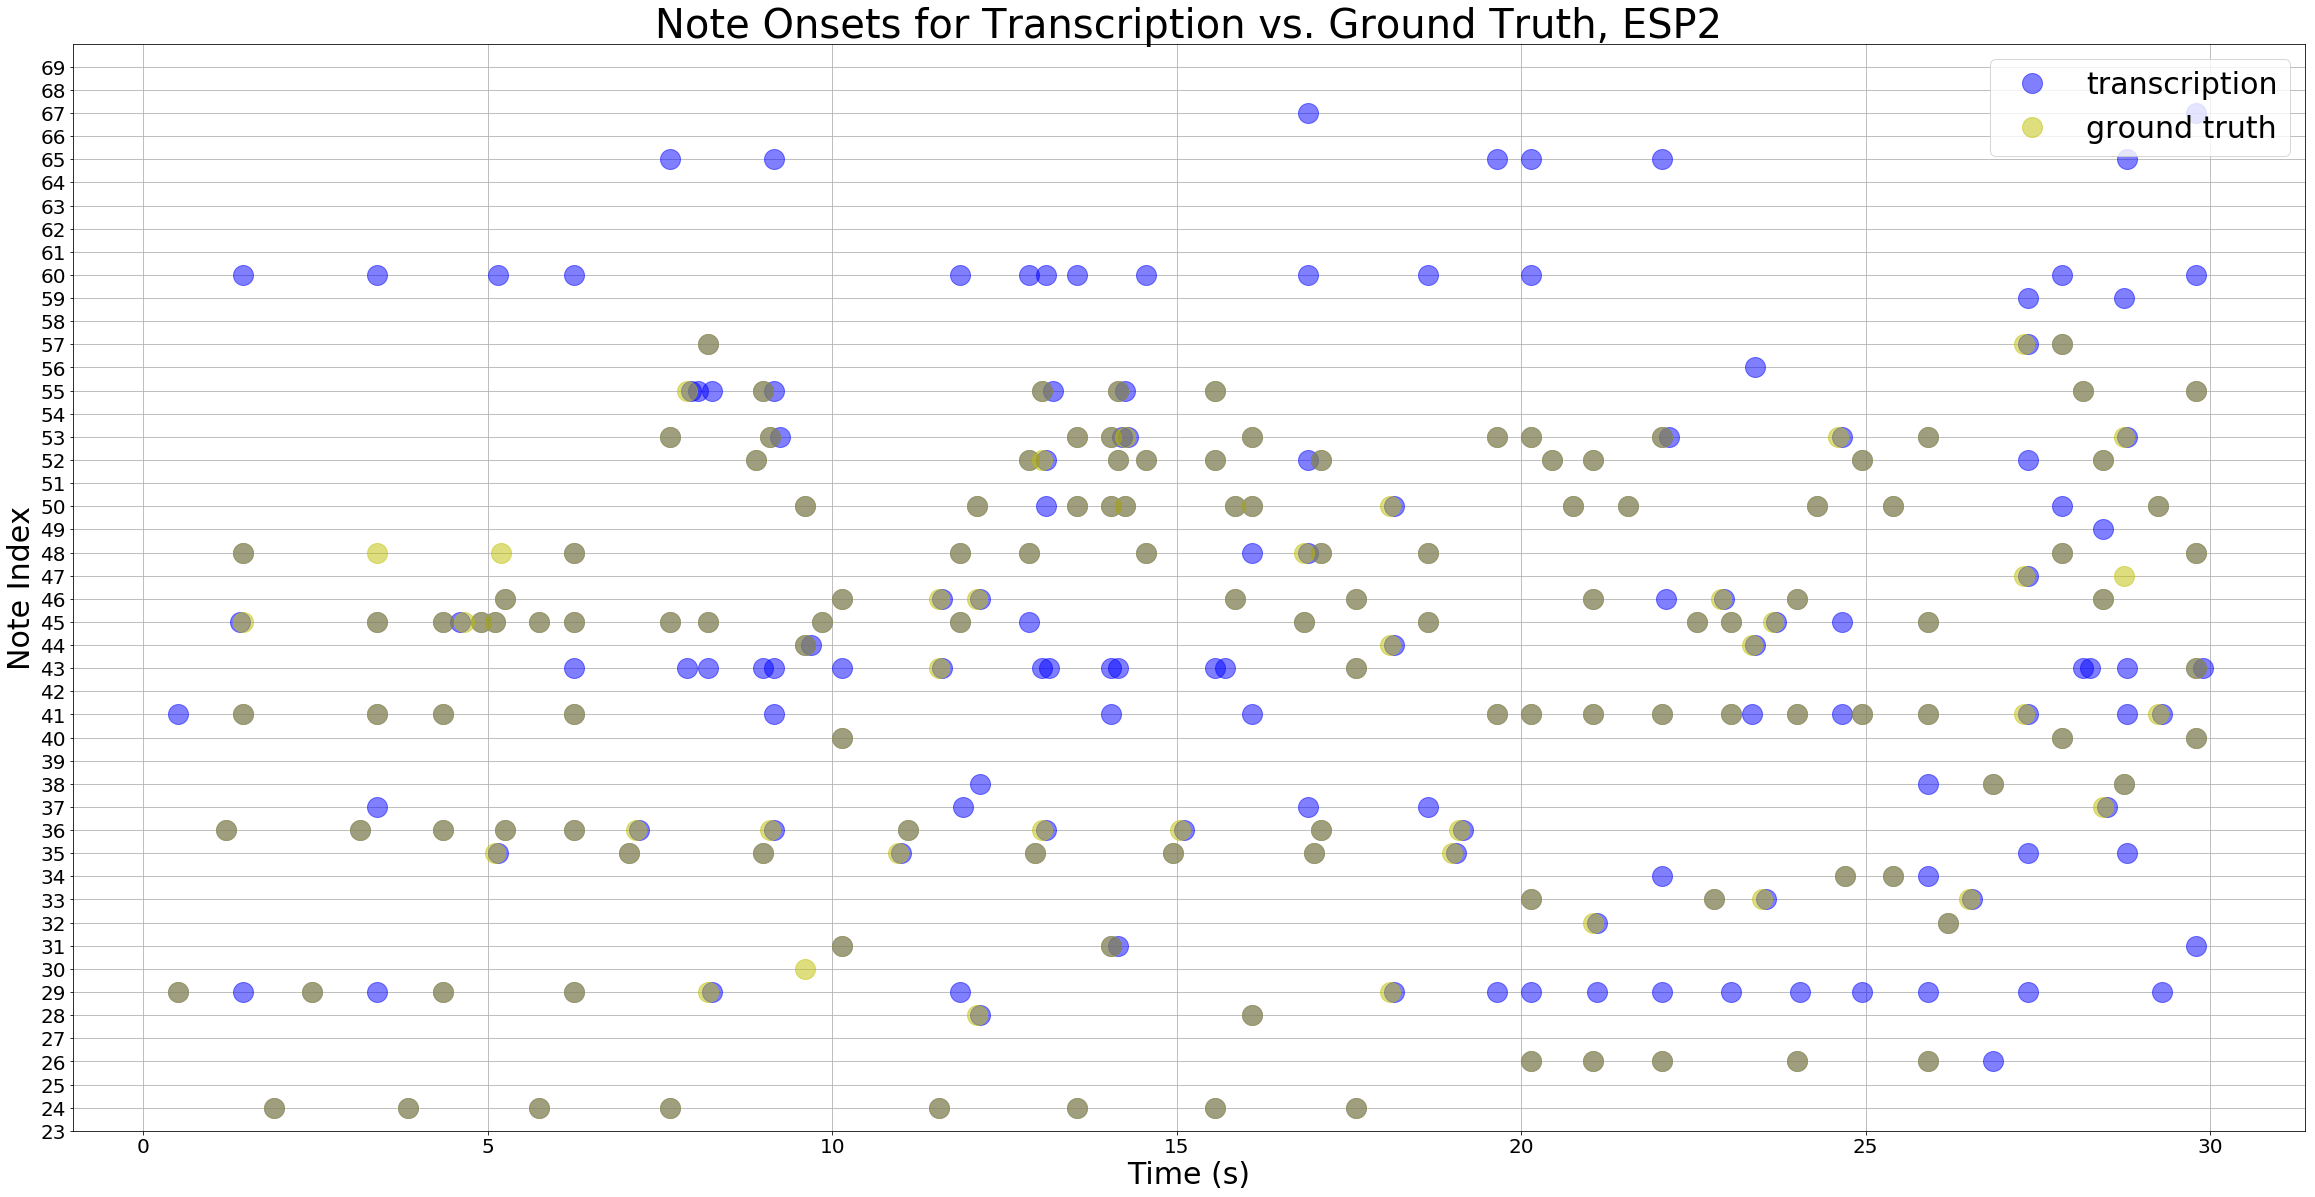

In [58]:
# plot the transcription vs ground-truth, onsets only
fig = plt.figure(figsize=(40,20))
plt.plot(np.asarray(x1)/20,y1,'bo',alpha=0.5,label = 'transcription', markersize=20)
plt.plot(np.asarray(x2)/20,y2,'yo',alpha=0.5,label = 'ground truth', markersize = 20)
plt.legend(loc = "upper right",prop={'size':30})
ax = fig.add_subplot(1,1,1)
major_ticks = np.arange(lownote,highnote+3)
ax.set_yticks(major_ticks)
ax.set_xticks(np.arange(0,31,5))
ax.grid(True)
ax.tick_params(axis='both', which='major', labelsize=20)
plt.ylim([23,highnote+3])
plt.title('Note Onsets for Transcription vs. Ground Truth, ' + 'ESP2',fontsize=40)
plt.xlabel('Time (s)',fontsize='30')
plt.ylabel('Note Index',fontsize="30")
plt.show()

In [59]:
# two shapes should match
print(gt_plot.shape)
print(onsets.shape)

(88, 1200)
(88, 1200)


In [60]:
# generate MIDI files for ground-truth and transcription to compare audio

# x1 is transcribed, x2 is ground-truth
track    = 0
channel  = 0
time     = 0   # In beats

# duration of each note in the MIDI file. Set to shorter to hear onsets better
duration = 0.2   # In beats

# we choose 60BPM because that allows easy divisions by seconds
tempo    = 60  # In BPM
volume   = 100 # 0-127, as per the MIDI standard

gt_track = MIDIFile(1) # One track, defaults to format 1 (tempo track
                     # automatically created)
gt_track.addTempo(track,time, tempo)

for i in range(len(x2)):
    # time windows progress by 50ms
    t = x2[i] * 0.050
    # MIDI pitch offset is 21, i.e. lowest note on piano is MIDI note number #21
    pitch = y2[i] + 21
    gt_track.addNote(track,channel,pitch,t,duration,volume)

# write midi track to disk
with open("gt_midi_" + abbrev + ".mid", "wb") as output_file:
    gt_track.writeFile(output_file)


C:\Users\conway\Miniconda2\envs\py35\lib\site-packages\midiutil\MidiFile.py:899: FutureWarning: Please explicitly set adjust_origin. Default behaviour will change in a future version.
  FutureWarning)


In [61]:
# repeat process for transcription
transcribed_track = MIDIFile(1)
transcribed_track.addTempo(track,time,tempo)
for i in range(len(x1)):
    t = x1[i] * 0.050
    pitch = y1[i] + 21
    transcribed_track.addNote(track,channel,pitch,t,duration,volume)
with open("transcribed_midi_" + abbrev + ".mid", "wb") as output_file:
    transcribed_track.writeFile(output_file)

C:\Users\conway\Miniconda2\envs\py35\lib\site-packages\midiutil\MidiFile.py:899: FutureWarning: Please explicitly set adjust_origin. Default behaviour will change in a future version.
  FutureWarning)
